In [1]:
require(data.table)
require(ggplot2)
require(pbapply)
require(viridis)
pboptions(type="timer")

Loading required package: data.table

Loading required package: ggplot2

Loading required package: pbapply

Loading required package: viridis

Loading required package: viridisLite



In [2]:
root_path = "../data/3D_David/"
#list.files(file.path(root_path))
#list.files(file.path(root_path, "DW_models"))

In [3]:
probe_meta = fread(file.path(root_path, "probes_chrX46.csv"))
#head(probe_meta)

hic_matrix = fread(file.path(root_path, "mat_hic_46plex.csv"))
#hic_matrix[1:5, 1:5]

In [4]:
hic_data = as.data.table(expand.grid(1:45, 1:45))
setnames(hic_data, LETTERS[1:2])

In [5]:
hic_data$hic_freq = as.matrix(hic_matrix)[as.matrix(hic_data[, .(A, B)])]

In [6]:
coords_dw = rbindlist(pblapply(0:195, function(file_id) {
    coords = fread(file.path(root_path, "DW_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

coords_rl = rbindlist(pblapply(0:175, function(file_id) {
    coords = fread(file.path(root_path, "RL_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [7]:
print(sprintf("Number of locations in DW: %d", coords_dw[, .N, by=file_id][, unique(N)]))
print(sprintf("Number of DW structures: %d", coords_dw[, .N, by=region][, unique(N)]))

print(sprintf("Number of locations in RL: %d", coords_rl[, .N, by=file_id][, unique(N)]))
print(sprintf("Number of RL structures: %d", coords_rl[, .N, by=region][, unique(N)]))

[1] "Number of locations in DW: 45"
[1] "Number of DW structures: 196"
[1] "Number of locations in RL: 45"
[1] "Number of RL structures: 176"


In [8]:
hic_data_dw = rbindlist(pblapply(1:196, function(current_file_id) {
    hic_data2 = copy(hic_data)
    hic_data2$dist3d = as.matrix(dist(coords_dw[file_id == current_file_id, .(x, y, z)]))[as.matrix(hic_data[, .(A, B)])]
    hic_data2$file_id = current_file_id
    return(hic_data2)
}))
hic_data_dw[, method := "DW"]

hic_data_rl = rbindlist(pblapply(1:176, function(current_file_id) {
    hic_data2 = copy(hic_data)
    hic_data2$dist3d = as.matrix(dist(coords_rl[file_id == current_file_id, .(x, y, z)]))[as.matrix(hic_data[, .(A, B)])]
    hic_data2$file_id = current_file_id
    return(hic_data2)
}))
hic_data_rl[, method := "RL"]

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [9]:
pdata = rbindlist(list(hic_data_dw, hic_data_rl))

# Average distance

In [10]:
ppdata = pdata[, .(hic_freq=hic_freq[1], mean_dist3d=mean(dist3d)), by=c("A", "B", "method")]
#head(ppdata)

## Hi-C frequency versus average distance from OligoFISSEQ

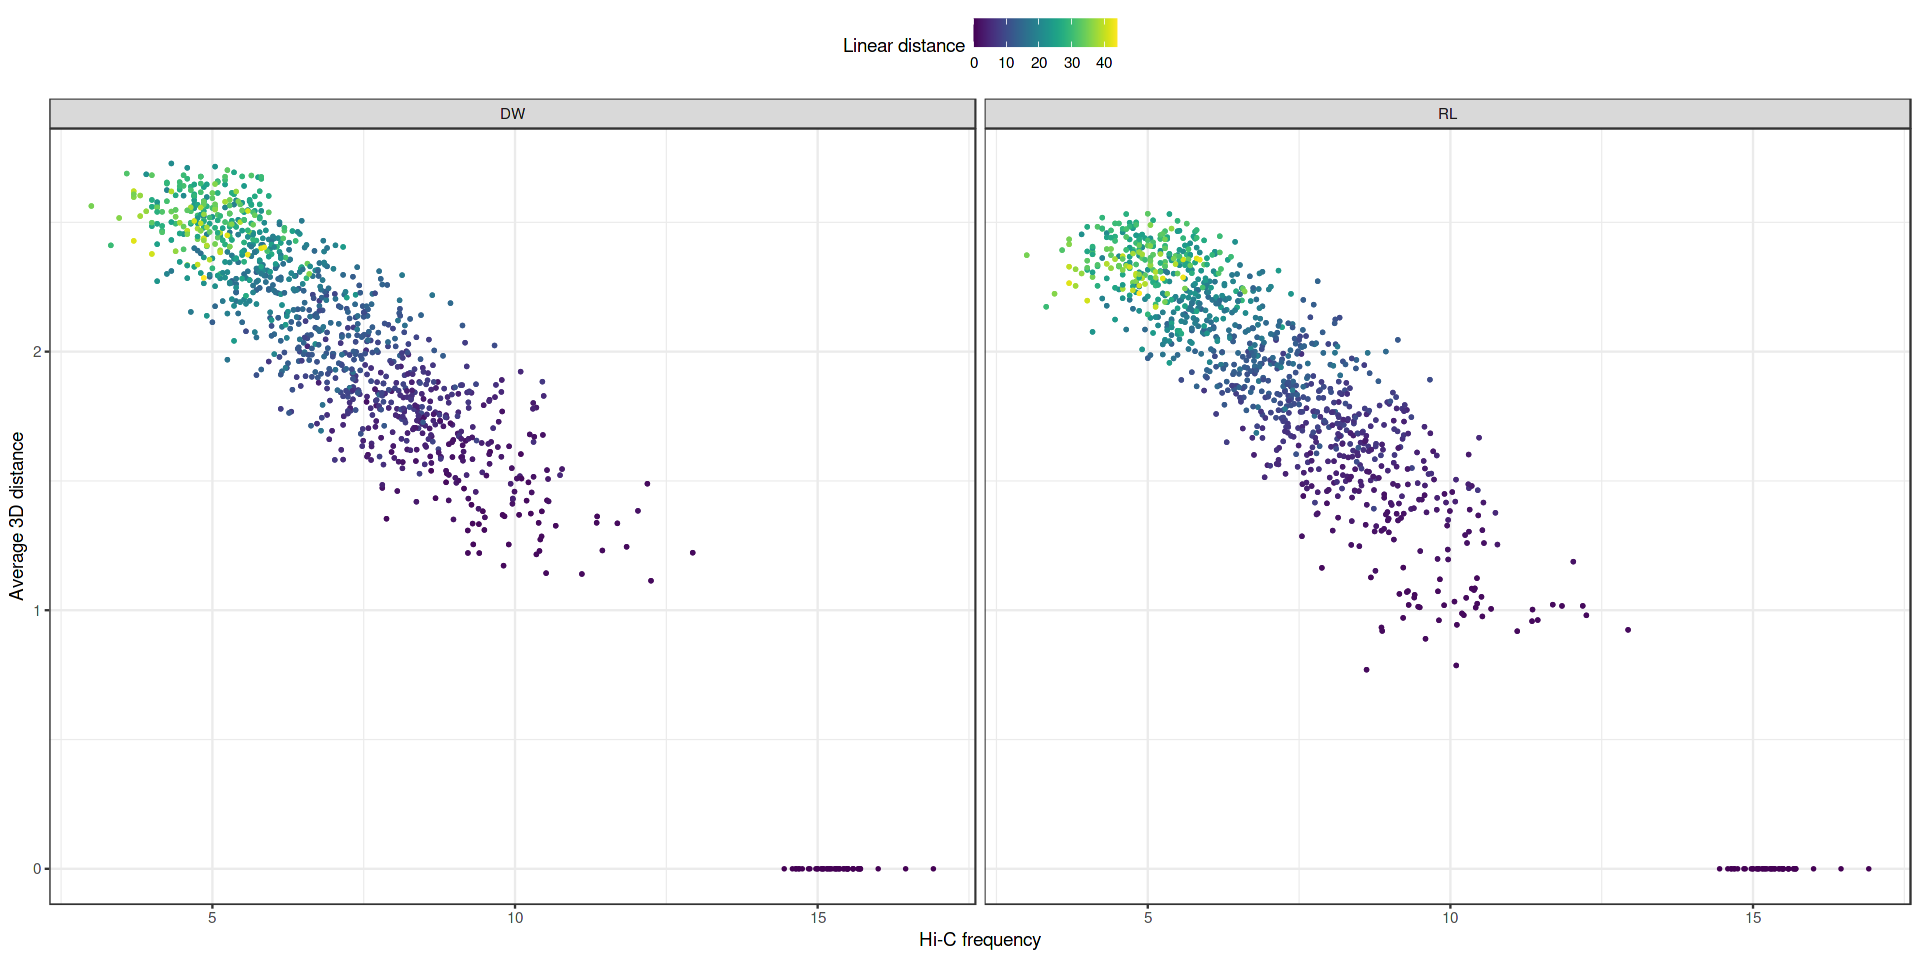

In [11]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(ppdata, aes(hic_freq, mean_dist3d, color=abs(A-B))) +
    geom_point(size=.5) + facet_wrap(~method) + theme_bw() +
    labs(x="Hi-C frequency", y="Average 3D distance", color="Linear distance") +
    scale_color_viridis() + theme(legend.position="top")

## Comparison of average 3D distance from OligoFISSEQ, using DW or RL
Overall, 3D coordinates in DW seem to be more distant, i.e., the chromosome territory has larger volume.

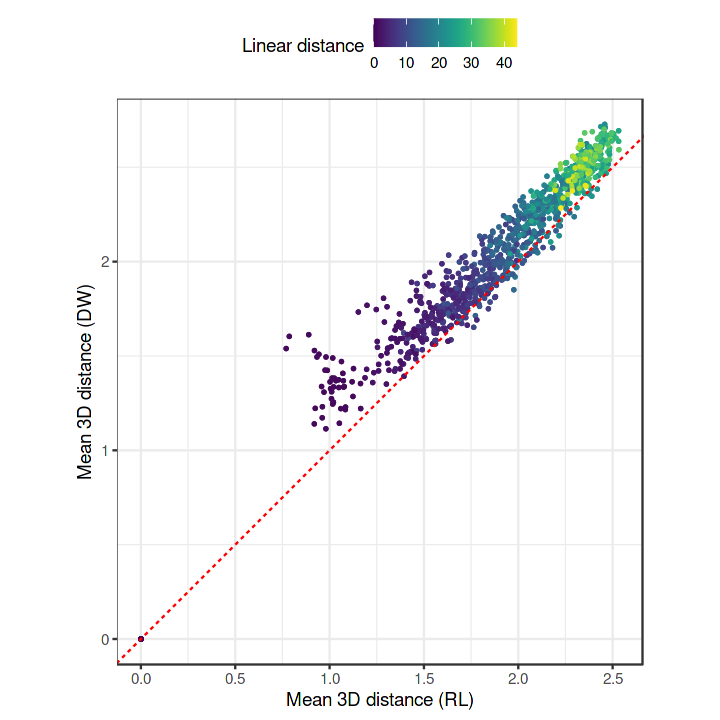

In [12]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(dcast(ppdata, A+B+hic_freq~method, value.var="mean_dist3d"), aes(RL, DW, color=abs(A-B))) +
    geom_point(size=.5) + geom_abline(slope=1, color="red", linetype="dashed") +
    theme_bw() + labs(x="Mean 3D distance (RL)", y="Mean 3D distance (DW)", color="Linear distance") +
    scale_color_viridis() + theme(legend.position="top") + coord_fixed()

# Contact frequency
Checking at different contact thresholds, from 1 to 3.2

In [13]:
cdata = rbindlist(pblapply(seq(1, 3.2, by=.2), function(thr) {
    pdata[, .(passes_thr=dist3d <= thr, dist3d, hic_freq), by=c("A", "B", "file_id", "method")
         ][,.(hic_freq=hic_freq[1], fcontacts=sum(passes_thr)/.N, thr=thr), by=c("A", "B", "method")]
}, cl=4))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


## Hi-C frequency and contact frequency from OligoFISSEQ, using DW or RL

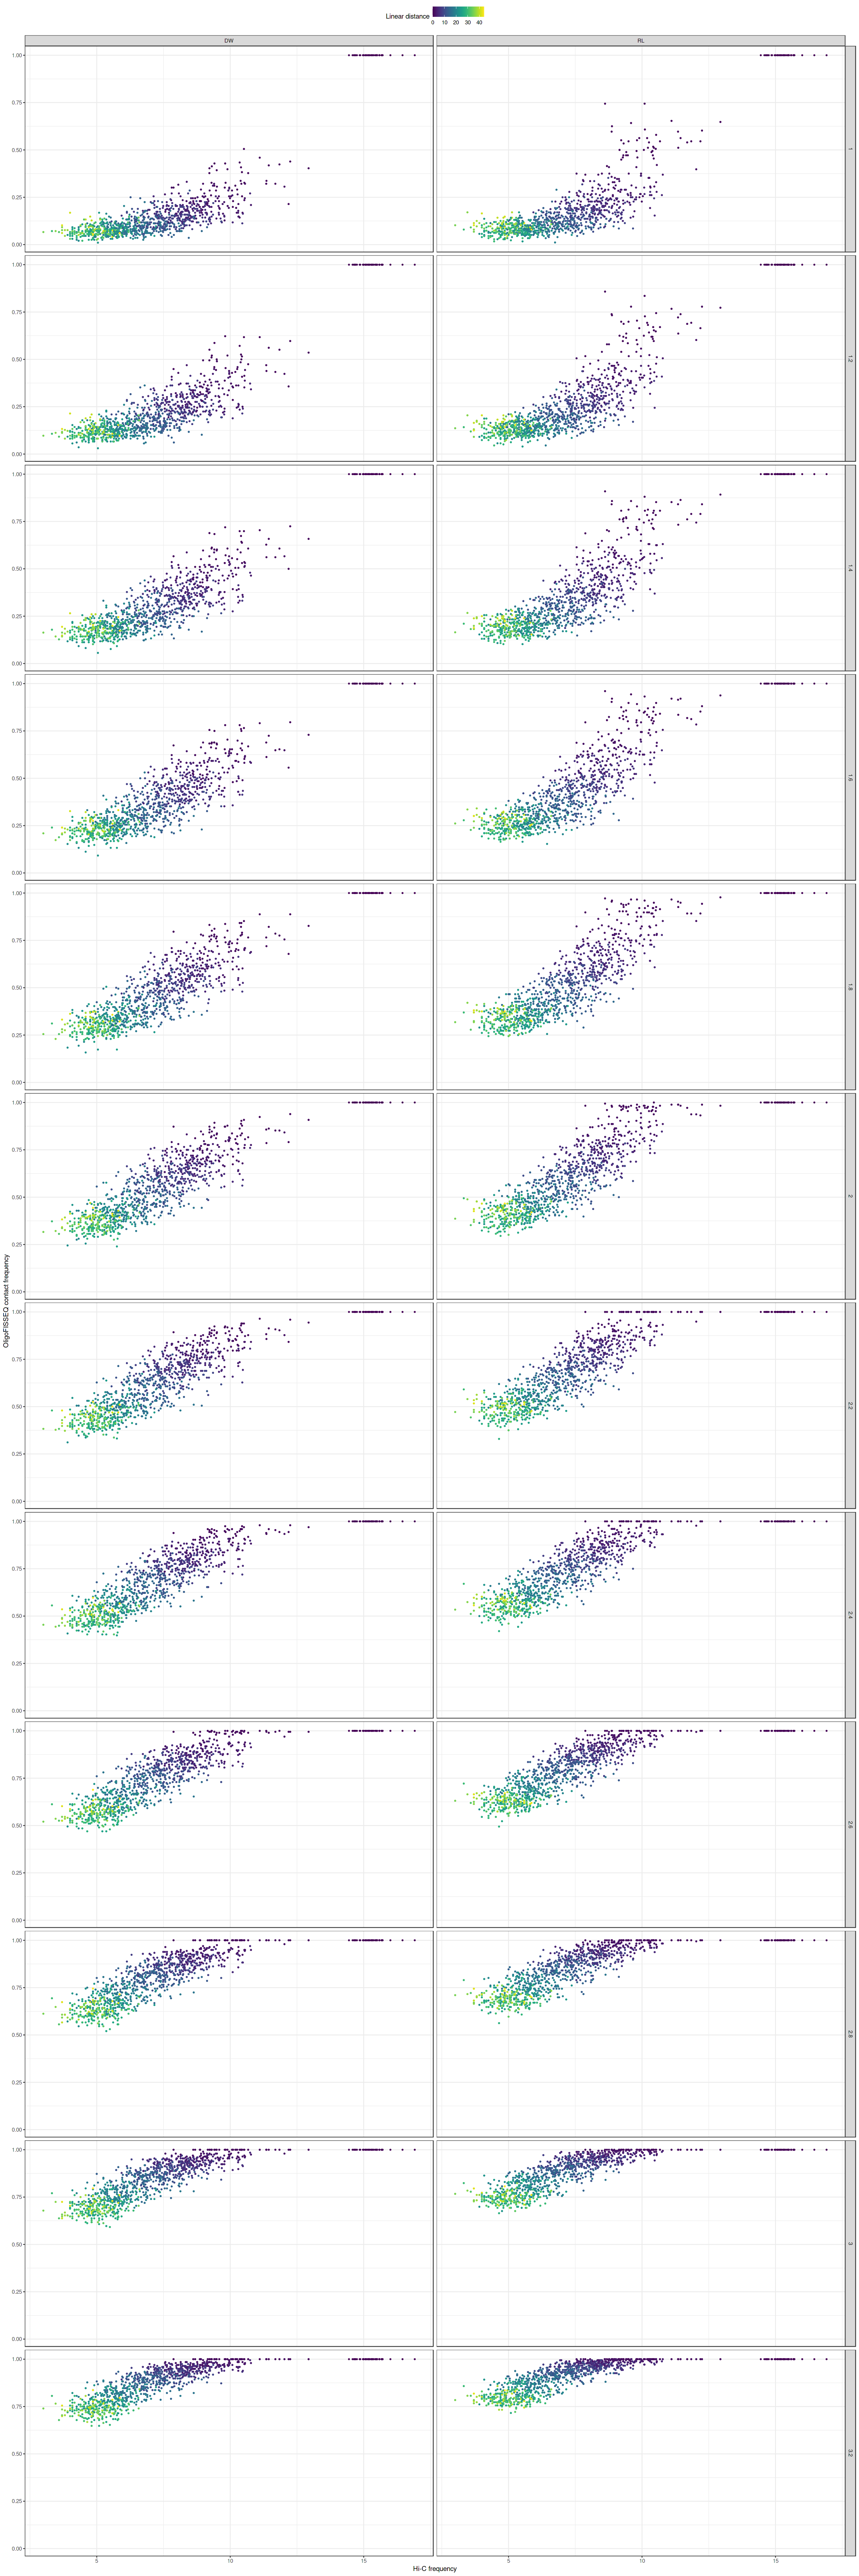

In [14]:
options(repr.plot.width=20, repr.plot.height=60)
ggplot(cdata, aes(x=hic_freq, y=fcontacts, color=abs(A-B))) + geom_point(size=.5) + facet_grid(~thr~method) +
    theme_bw() + labs(x="Hi-C frequency", y="OligoFISSEQ contact frequency", color="Linear distance") +
    theme(legend.position="top") + scale_color_viridis()

## Direct comparison of contact frequency at different contact thresholds

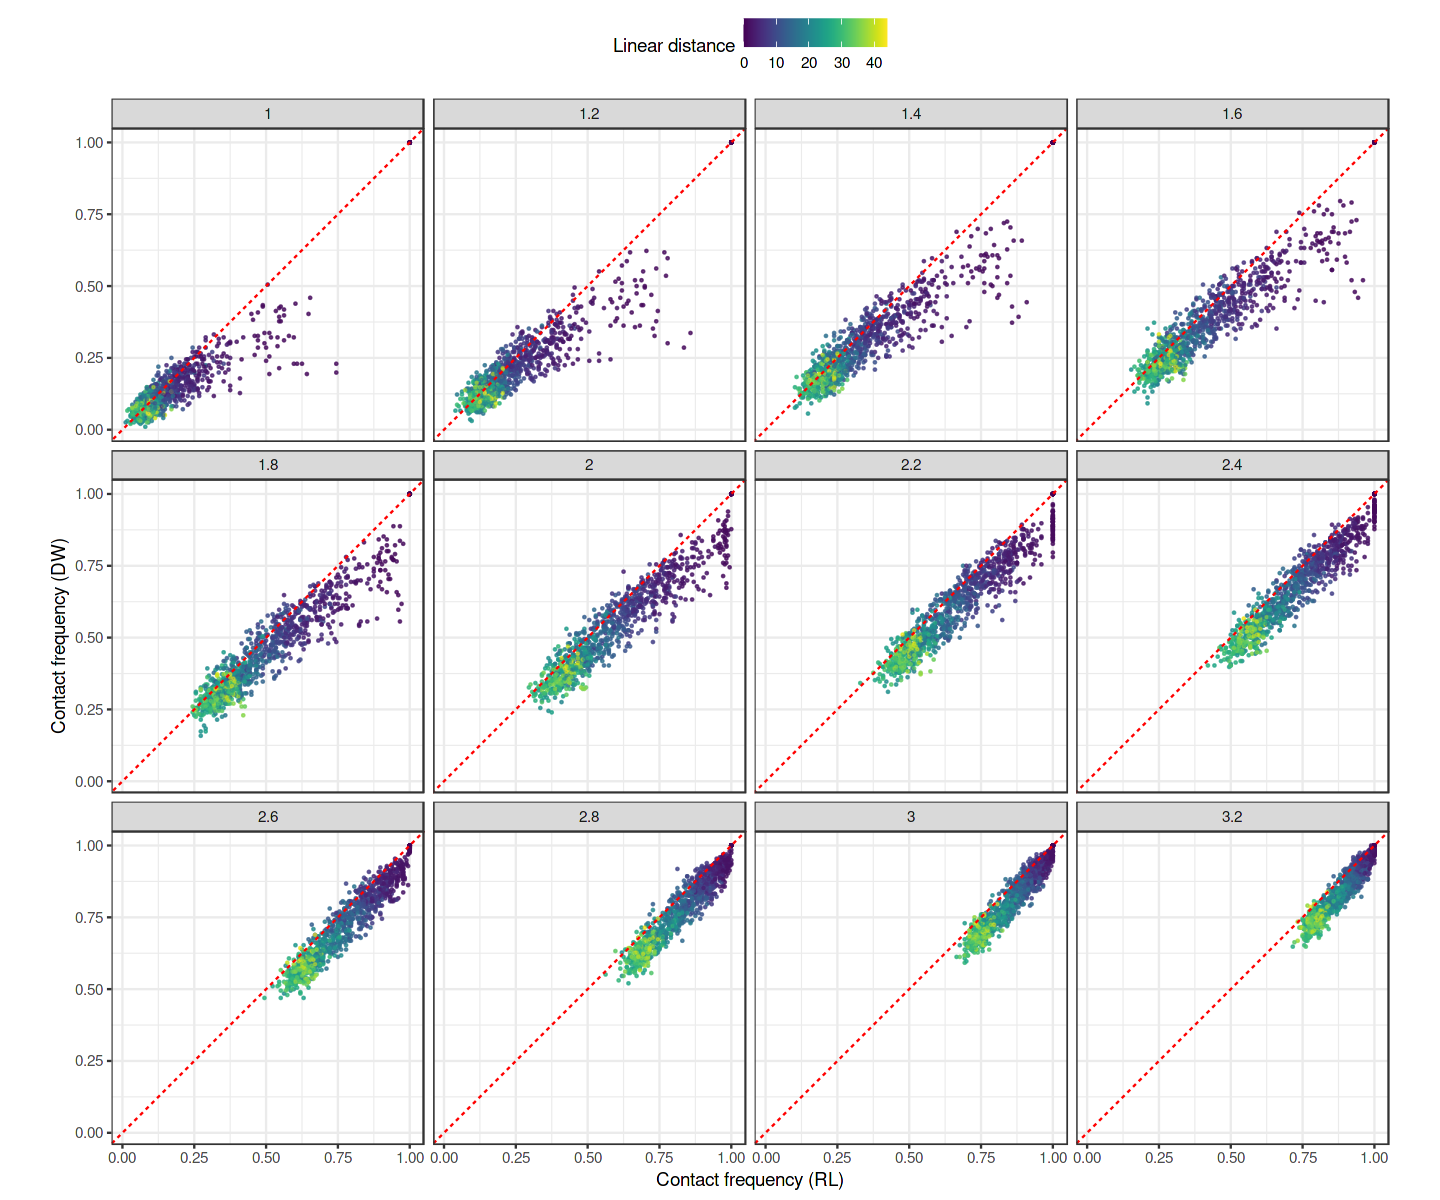

In [15]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(dcast(cdata, A+B+hic_freq+thr~method, value.var="fcontacts"), aes(RL, DW, color=abs(A-B))) +
    geom_point(size=.25, alpha=.5) + facet_wrap(~thr) + theme_bw() +
    geom_abline(slope=1, color="red", linetype="dashed") + coord_fixed() +
    scale_color_viridis() + labs(x="Contact frequency (RL)", y="Contact frequency (DW)", color="Linear distance") +
    theme(legend.position="top")